In [22]:
!pip install mesa

In [24]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt

# Define triad genders and hybrids
GENDERS = ["Solari", "Lunari", "Terran"]
HYBRIDS = ["Solari-Lunari", "Lunari-Terran", "Terran-Solari", "Triune"]
TERRITORIES = ["North", "South", "East"]

class TriadicAgent(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.gender = random.choice(GENDERS)
        self.hybrid = random.choice(HYBRIDS) if random.random() < 0.2 else None
        self.satisfaction = random.uniform(0.7, 1.0)
        self.territory = random.choice(TERRITORIES)

    def interact(self, other):
        # Same territory: more positive interaction
        territory_bonus = 0.05 if self.territory == other.territory else -0.05

        # Compatibility bonus/penalty
        if self.gender == other.gender:
            self.satisfaction += 0.03 + territory_bonus
        elif other.hybrid or self.hybrid:
            self.satisfaction += 0.01 + territory_bonus
        else:
            self.satisfaction -= 0.04

        self.satisfaction = max(0.0, min(1.0, self.satisfaction))

    def step(self):
        # Random interaction with a peer
        if self.model.num_agents > 1:
            other = self.random.choice([a for a in self.model.agents if a != self])
            self.interact(other)

        # Societal policy effect
        if self.model.policy == "equal_rights":
            self.satisfaction += 0.01
        elif self.model.policy == "favor_solari" and self.gender == "Solari":
            self.satisfaction += 0.02
        elif self.model.policy == "favor_solari":
            self.satisfaction -= 0.02

        self.satisfaction += random.uniform(-0.03, 0.03)
        self.satisfaction = max(0.0, min(1.0, self.satisfaction))

class TriadicSociety(Model):
    def __init__(self, N=100, policy="equal_rights"):
        super().__init__()
        self.num_agents = N
        self.policy = policy

        for _ in range(self.num_agents):
            TriadicAgent(self)

        self.datacollector = DataCollector(
            model_reporters={
                "Solari": lambda m: m.count_gender("Solari"),
                "Lunari": lambda m: m.count_gender("Lunari"),
                "Terran": lambda m: m.count_gender("Terran"),
                "Hybrids": self.count_hybrids,
                "AvgSatisfaction": self.average_satisfaction,
                "North": lambda m: m.count_territory("North"),
                "South": lambda m: m.count_territory("South"),
                "East": lambda m: m.count_territory("East")
            }
        )

    def count_gender(self, gender):
        return sum(1 for a in self.agents if a.gender == gender)

    def count_territory(self, territory):
        return sum(1 for a in self.agents if a.territory == territory)

    def count_hybrids(self):
        return sum(1 for a in self.agents if a.hybrid is not None)

    def average_satisfaction(self):
        return sum(a.satisfaction for a in self.agents) / self.num_agents

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("step")

# Run the simulation with territory and policy effects
model = TriadicSociety(N=100, policy="equal_rights")
for _ in range(50):
    model.step()

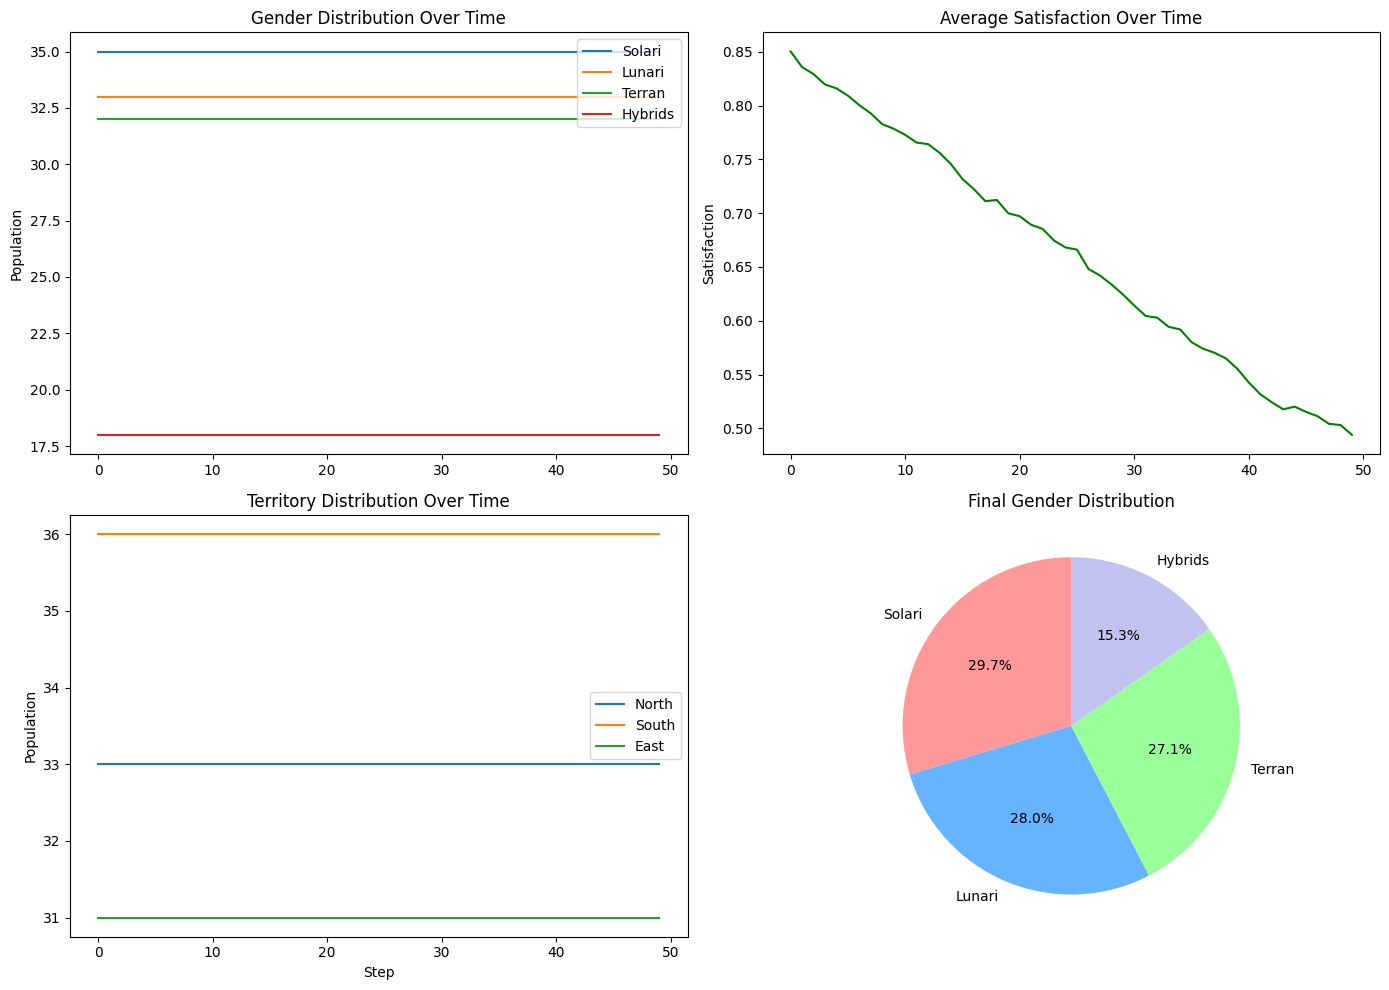

In [25]:
# Get results from the model
results = model.datacollector.get_model_vars_dataframe()

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Gender Distribution
results[["Solari", "Lunari", "Terran", "Hybrids"]].plot(ax=axs[0, 0])
axs[0, 0].set_title("Gender Distribution Over Time")
axs[0, 0].set_ylabel("Population")
axs[0, 0].legend(loc="upper right")

# Plot Average Satisfaction
results["AvgSatisfaction"].plot(ax=axs[0, 1], color="green")
axs[0, 1].set_title("Average Satisfaction Over Time")
axs[0, 1].set_ylabel("Satisfaction")

# Plot Territory Distribution
results[["North", "South", "East"]].plot(ax=axs[1, 0])
axs[1, 0].set_title("Territory Distribution Over Time")
axs[1, 0].set_ylabel("Population")
axs[1, 0].set_xlabel("Step")

# Pie Chart of Final Gender Distribution
final_counts = results[["Solari", "Lunari", "Terran", "Hybrids"]].iloc[-1]
axs[1, 1].pie(
    final_counts,
    labels=final_counts.index,
    autopct="%1.1f%%",
    colors=["#ff9999", "#66b3ff", "#99ff99", "#c2c2f0"],
    startangle=90
)
axs[1, 1].set_title("Final Gender Distribution")

# Improve layout
plt.tight_layout()
plt.show()